In [ ]:
# !conda install -y -n nbenv1 -c conda-forge regionmask cartopy pygeos
#!conda install -y -n nbenv1 nc-time-axis

In [1]:
# import cf, cfplot as cfp
import numpy as np
import scipy as sp
import sys
import os
from netCDF4 import Dataset
import netCDF4 as nc



%matplotlib inline
import matplotlib
import xarray as xr
import matplotlib.pyplot as plt
import warnings

import matplotlib.pyplot as plt
import matplotlib.path as mpath
# Quick plot to show the results
from cartopy import config
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import scipy.ndimage as ndimage0
# from mpl_toolkits.basemap import Basemap
# from mpl_toolkits.basemap import addcyclic
from cartopy.util import add_cyclic_point
import matplotlib.pylab as pl
from scipy import stats
import regionmask
import glob
import dask
from general_functions import *
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
seas='JJA'
reg='IPCC'
nyear=1
rebasing=False

if (seas == "DJF"):
    sind=1
else:
    sind=0

print(sind)
def rebase(dataset,files):
    # ds = xr.open_dataset('intermediate_files/stable/gmst/tas_gmst_bq777.nc') #,engine='zarr')
    dates=dataset[0,].dropna(dim='year',how='all').year  
    datasets = []
    test=dataset
    for i in np.arange(0,int(dataset.shape[0])):
        tmp=test[i,:].dropna(dim='year',how='all')
        # print(tmp)
        # print(tmp.shape)
        # print(dates)
        tmp['year']=dates
#         print(tmp.year)
        datasets.append(tmp)
    dsnew = xr.concat(datasets, dim='cases')
    # print(dsnew)
    return(dsnew)

def preprocess(ds):
    print(ds.encoding['source'])
    return(ds)

def seasaverage_3(var,seas):
    season={'DJF':0,'JFM':1,'FMA':2,'MAM':3,'AMJ':4,'MJJ':5,'JJA':6,'JAS':7,'ASO':8,'SON':9,'OND':10,'NDJ':11,'ann':None}
    seasindex=season[seas]
    if (seas == 'ann'):
        var_seas=var.groupby('time.year').mean('time')
    else:
        if (var.ndim == 4):
            var_seas=var.rolling(min_periods=3, center=True, time=3).mean()[:,seasindex::12,:,:]
            var_seas=var_seas.groupby('time.year').mean('time') #rename({"time":"year"})
        elif (var.ndim == 3): 
            var_seas=var.rolling(min_periods=3, center=True, time=3).mean()[seasindex::12,:,:]
            var_seas=var_seas.groupby('time.year').mean('time')
        print(var_seas)
    return(var_seas)

zipgmststab=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_*.nc'))
zipgmst=xr.open_mfdataset(zipgmststab,combine='nested',concat_dim='cases',preprocess=preprocess)['tas']
zipgmst=np.nanmean(rebase(zipgmst,zipgmststab),axis=1)
# print(zipgmst)
def sortbygmst(input):
    input = [x for _,x in sorted(zip(zipgmst,input))]
    return(input)


gmststab=sortbygmst(sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_*.nc')))
gmst=xr.open_mfdataset(gmststab,combine='nested',concat_dim='cases',preprocess=preprocess)['tas']
gmst=rebase(gmst,gmststab)
gmstbase=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/historical/gmst/tas_gmst_*.nc'))
gmstref=xr.open_mfdataset(gmstbase,combine='nested',concat_dim='cases')['tas']
base=gmstref[:,0:50].mean('cases').mean('year')
gmst2=gmst-base

    # calculate transient_gmst 

gmstssp=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/ssp370/gmst/tas_gmst_*.nc'))
gmstsspt=xr.open_mfdataset(gmstssp,combine='nested',concat_dim='cases')['tas']
gmstssp370=gmstsspt-base

0
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bq777.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bu607.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw848.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw987.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bz227.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_cd269.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bq777.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw848.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bz227.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_cd269.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw987.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_fi

In [3]:
seas='JJA'
var='pr'
stable={}
transient={}
stable_r={}
stable['pr']=rebase(xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_stable.nc')['pr_region_mean'],"").polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
print(stable['pr'].shape)
transient['pr']=xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_transient.nc')['pr_region_mean'].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
print(stable['pr'].shape)
print(transient['pr'].shape)
region=xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_stable.nc')['names'].values


(6, 46)
(6, 46)
(16, 46)


In [4]:
def check_sign_agreement(input):
    pos_neg=np.where((input > 0)&(~np.isnan(input)), 1.0, -1.0)
    values=np.sum(pos_neg,axis=0)
    return(values)
stable=rebase(xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_stable.nc')['pr_region_mean'],"").polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
print(stable)
print(check_sign_agreement(stable)[0])

[[ 0.00979724  0.01068004  0.00701385  0.00956277 -0.00397183  0.00489123
  -0.0022756   0.00298735  0.00867918  0.00206641 -0.00734851 -0.00751466
   0.00895871  0.01347566  0.0131538   0.00709355  0.00620566  0.01451711
  -0.0024283   0.010247   -0.00585138  0.00086716 -0.00205233  0.00147963
   0.00371755 -0.00635045 -0.0059308  -0.00648427  0.01419407  0.00519288
   0.01020354  0.00303083  0.0110029   0.01730572  0.01044841  0.00435861
  -0.01324499  0.00673854 -0.00269941 -0.00410323 -0.00065175 -0.00218851
  -0.00324311  0.00294755  0.02045914  0.01620782]
 [ 0.02749917  0.01354069  0.01492838  0.00430268  0.00094908  0.00525088
  -0.00676706  0.00293037  0.01500944 -0.00805888 -0.00849433 -0.01599302
  -0.01489449  0.00152444  0.00630027  0.00348193  0.00886837  0.00626721
   0.00257483  0.00393722  0.02898035  0.00463832  0.0031183   0.0177625
   0.00968093 -0.00286569 -0.00666137 -0.01074761  0.02159013  0.0130395
   0.01941975  0.0034933   0.01047342  0.02315925  0.01497165  

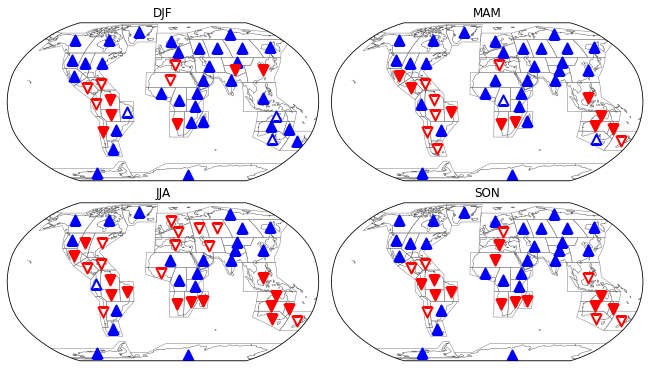

In [25]:
def check_sign_agreement_s(input):
    pos_neg=np.where((input > 0)&(~np.isnan(input)), 1.0, -1.0)
    values=np.sum(pos_neg,axis=0)
    # print(values)
    if (values >= 5.): 
        col='blue'
    elif ((values >0.) and (values <5.)): 
        col='blue'
    elif ((values <0.) and (values > -5.)): 
        col='red'
    elif (values <=-5.): 
        col='red'
    elif ((values == 0) and (np.mean(input) > 0)): 
        col='blue'
    elif ((values == 0) and (np.mean(input) < 0)): 
        col='red'
    return(col)

def check_sign_agreement_t(input):
    pos_neg=np.where((input > 0)&(~np.isnan(input)), 1.0, -1.0)
    values=np.sum(pos_neg,axis=0)
    # print(values)
    if (values >= 13.): 
        col='blue'
    elif ((values >0.) and (values <13.)): 
        col='blue'   #'deepskyblue','lightsalmon'
    elif ((values <0.) and (values > -13.)): 
        col='red'
    elif (values <=-13.): 
        col='red'
    elif ((values == 0) and (np.mean(input) > 0)): 
        col='blue'
    elif ((values == 0) and (np.mean(input) < 0)): 
        col='red'
    return(col)


reg='IPCC'
seas=['DJF','MAM','JJA','SON'] #'DJF','MAM','JJA','SON']
# print(center[1])
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

f, axarr = plt.subplots(nrows=2, ncols=2,figsize=(9, 2.5*2), constrained_layout=True,subplot_kw=dict(projection=ccrs.Robinson()))
ax = axarr.flatten()
# ax.coastlines(color="black",alpha=1)
# mask = regionmask.defined_regions.ar6.land.mask(lon, lat)
s=0
for seas in seas:
    ax[s].set_global()
    regionmask.defined_regions.ar6.land.plot(
    ax=ax[s], add_label=False, line_kws=dict(lw=0.5, color="gray",zorder=1)
)
    stable=rebase(xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_stable.nc')['pr_region_mean'],"").polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    transient=xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_transient.nc')['pr_region_mean'].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    region=xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_stable.nc')['names'].values

    for r in np.arange(0,46):
        center=regionmask.defined_regions.ar6.land.centroids[r]
        # if ((np.mean(transient,axis=0)[r] > 0) and (np.mean(stable,axis=0)[r] > 0)):
        #     # if (rrr==0):
        #     #     lab='Increase in both'
        #     #     rrr=rrr+1
        #     # else:
        #     #     lab=''
        #     if ((np.abs((check_sign_agreement(stable[:,r]) >= 5.))) and (np.abs((check_sign_agreement(transient[:,r]) >= 13.)))):
        #         ax[s].scatter(center[0],center[1],s=100,marker="^",facecolors='blue', edgecolors='blue',linewidth=2,transform=ccrs.PlateCarree(),zorder=2) #,label=lab)
        #     elif ((np.abs((check_sign_agreement(stable[:,r]) <= 5.))) and (np.abs((check_sign_agreement(transient[:,r]) <= 13.)))):
        #         ax[s].scatter(center[0],center[1],s=100,marker="^",facecolors='deepskyblue', edgecolors='deepskyblue',linewidth=2,transform=ccrs.PlateCarree(),zorder=2) #,label=lab)
        # elif ((np.mean(transient,axis=0)[r] > 0) and (np.mean(stable,axis=0)[r] < 0)):
        #     ax[s].scatter(center[0],center[1],s=100,marker="^",facecolors='white', edgecolors='blue',linewidth=2,transform=ccrs.PlateCarree(),zorder=2)
        # elif ((np.mean(transient,axis=0)[r] < 0) and (np.mean(stable,axis=0)[r] < 0)):
        #     if ((check_sign_agreement(stable[:,r]) >= 5.) or (check_sign_agreement(stable[:,r]) <= -5.)):
        #         ax[s].scatter(center[0],center[1],s=100,marker="v",facecolors='red', edgecolors='red',linewidth=2,transform=ccrs.PlateCarree(),zorder=2)
        #     else: 
        #         ax[s].scatter(center[0],center[1],s=100,marker="v",facecolors='lightsalmon', edgecolors='red',linewidth=2,transform=ccrs.PlateCarree(),zorder=2)
        # elif ((np.mean(transient,axis=0)[r] < 0) and (np.mean(stable,axis=0)[r] > 0)):
        #     ax[s].scatter(center[0],center[1],s=100,marker="v",facecolors='white', edgecolors='red',linewidth=2,transform=ccrs.PlateCarree(),zorder=2)


        if ((np.mean(transient,axis=0)[r] > 0) and (np.mean(stable,axis=0)[r] > 0)):
            ax[s].scatter(center[0],center[1],s=100,marker="^",facecolors=check_sign_agreement_s(stable[:,r]), edgecolors=check_sign_agreement_t(transient[:,r]),linewidth=2,transform=ccrs.PlateCarree(),zorder=2) #,label=lab)
        elif ((np.mean(transient,axis=0)[r] < 0) and (np.mean(stable,axis=0)[r] < 0)):
            ax[s].scatter(center[0],center[1],s=100,marker="v",facecolors=check_sign_agreement_s(stable[:,r]), edgecolors=check_sign_agreement_t(transient[:,r]),linewidth=2,transform=ccrs.PlateCarree(),zorder=2)
        elif ((np.mean(transient,axis=0)[r] < 0)):
            ax[s].scatter(center[0],center[1],s=100,marker="v",facecolors='white', edgecolors=check_sign_agreement_t(transient[:,r]),linewidth=2,transform=ccrs.PlateCarree(),zorder=2)
        elif ((np.mean(transient,axis=0)[r] > 0)):
            ax[s].scatter(center[0],center[1],s=100,marker="^",facecolors='white', edgecolors=check_sign_agreement_t(transient[:,r]),linewidth=2,transform=ccrs.PlateCarree(),zorder=2)
    ax[s].set_title(seas)
    s=s+1
# ax[3].legend()
plt.savefig('summary_figure_precip.png',dpi=300)
    
    # stable['pr'].plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=True)

In [ ]:
linelist=[]
# fig, axes = plt.subplots(2,2,figsize=(10,2.5))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 2.4), constrained_layout=True,squeeze=False) # width was 9
ax=ax.flatten()
ax[0].axhline(y=0, color='black', linestyle='-',alpha=0.8)
ax[0].axhline(y=52, color='black', linestyle='-',alpha=0.8)
# ax[0].axhline(y=53, color='black', linestyle='-',alpha=0.8)
for r in np.arange(0,1):
    ax[0].plot(transient[var].year.values,transient[var][r,:].rolling(min_periods=1, center=True, year=1).mean().values,color='brown',linewidth=0.75,alpha=0.7)
lines, = ax[0].plot(transient[var].year.values,np.mean(transient[var][:,:].values,axis=0),color='brown',linewidth=2)
linelist.append(lines)    
i=0
# for c in ssp3_real_ind:
for c in np.arange(0,6):
    lines,= ax[0].plot(stable[var].year[0:eyear].values,stable[var][c,0:eyear].rolling(min_periods=16, center=True, year=16).mean(),color=cmap(col[i]),linewidth=2,alpha=1)
    linelist.append(lines)
    i+=1
# lim=np.round(np.nanmax((np.abs(np.nanmin(test['pr'][:,:].rolling(min_periods=16, center=True, year=16).mean().values)),
#               np.nanmax(test['pr'][:,:].rolling(min_periods=16, center=True, year=16).mean().values),np.abs(np.nanmin(np.mean(transient_data[:,:],axis=0))),np.nanmin(np.mean(transient_data[:,:],axis=0)))),2)
# print(lim)
ax[0].set_ylim(ymax = 20, ymin = -70.0)
ax[0].set_title('Precipitation timeseries for '+str(region))
ax[0].tick_params(axis='both', which='major', labelsize=15)
locs, labels = plt.yticks()  # Get the current locations and labels.
plt.yticks(np.arange(-60,21, step=20))  # Set label locations.
# xticks([0, 1, 2], ['January', 'February', 'March'],
#        rotation=20)  # Set text labels and properties.
# xticks([])  # Disable xticks.
ax[0].set_xlabel('Year',fontsize=14)
ax[0].set_ylabel('%',fontsize=14)
# ax[0].legend([linelist[0],linelist[1],linelist[2],linelist[3],linelist[4],linelist[5],linelist[6]], ['SSP370 parent transient run','hist 2014','2020 SSP370','2025 SSP370','2025 SSP245','2030 SSP119','2040 SSP370'],frameon=False,fontsize=10,ncol=3)
# ax[0].legend([linelist[1],linelist[2],linelist[3],linelist[0]], ['2020 SSP370','2025 SSP370','2040 SSP370','SSP370 transient EM'],frameon=False,fontsize=10,ncol=3)
#axes[0].legend([linelist[0]], ['UKESM1 SSP3-7.0'],frameon=False,fontsize=10,ncol=3)

plt.savefig('paper_plots/ssp_reg_timeseries_'+seas+'_'+str(region)+'_'+str(nyear)+'_v2.png',dpi=300)


In [ ]:
var='jet'
stable[var]=xr.open_dataset('timeseries/jet_lat_JJA.nc')['jet_lat_Atlantic_stable'].rename({'year_1':'year'}) #,gmststab)
print(stable[var].shape)
transient[var]=xr.open_dataset('timeseries/jet_lat_JJA.nc')['jet_lat_Atlantic_transient'].rename({'year_2':'year'})

In [ ]:
for r in ssp3_real_ind:
    plt.scatter(stable['jet'][r,:],stable['pr'][r,:])
    plt.scatter(transient['jet'],transient['pr'],alpha=0.4)
    plt.axhline(y=0, color='black', linestyle='-',alpha=0.8)
    plt.figure()

In [ ]:
factor={'tas':1,'pr':86400,'txx':1,'psl':1./100,'ua_850':1.,'evspsbl':86400,'va_850':1.,'uas':1.,'vas':1.,'prw':1,'huss':1,'hurs':1,'mrso':1,'mrsos':1,'ts':1,'rsds':1,'clt':1}
seas='MAM'
var=['tas','psl','ua_850','pr','hurs','mrsos','huss','evspsbl','ts']
def trend_patterns(var):
    if (var == 'ua_850'):
        var2='ua'
    else:
        var2=var
    files=sortbygmst(sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/'+var+'/'+var+'_?????.nc')))
    tasfiles=xr.open_mfdataset(files,combine='nested',concat_dim='cases',preprocess=preprocess)
    stable[var]=rebase(seasaverage_3(tasfiles[var2],seas),files)*factor[var]
    
    files=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/ssp370/'+var+'/'+var+'_*.nc'))
    transientfiles=xr.open_mfdataset(files,combine='nested',concat_dim='cases',preprocess=preprocess)
    transient[var]=seasaverage_3(transientfiles[var2],seas)*factor[var]
    
    trend=stable[var].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    print(trend.shape)
    trend, lon2 = add_cyclic_point(trend, stable[var].lon, axis=2)
    global_trend=gmst2.polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    
    transient_trend=transient[var].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    transient_trend, lon2 = add_cyclic_point(transient_trend, transient[var].lon, axis=2)
    transient_gtrend=gmstssp370.polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    
    global_trend=np.broadcast_to(global_trend[:, np.newaxis, np.newaxis], (6, trend.shape[1], trend.shape[2]))
    transient_gtrend=np.broadcast_to(transient_gtrend[:, np.newaxis, np.newaxis], (16, transient_trend.shape[1], transient_trend.shape[2]))
    print(transient_trend.shape)
    return(trend,transient_trend,transient_gtrend,global_trend,stable[var].lat,lon2)

import pickle
filename = 'multi_var_trends_'+seas
if (os.path.exists(filename)):
    file = open(filename, 'rb')
    trend,transient_trend,transient_gtrend,global_trend,lat,lon = pickle.load(file)
    file.close()
else:
    # if (trend==None):
    print('nothing loaded')
    trend={}
    transient_trend={}
    transient_gtrend={}
    global_trend={}
    lat={}; lon={}
    for var in var[0:8]:
        print(var)
        trend[var],transient_trend[var],transient_gtrend[var],global_trend[var],lat[var],lon[var]=trend_patterns(var)
        print(trend.keys())
    import pickle
    filename = 'multi_var_trends_'+seas
    outfile = open(filename,'wb')
    pickle.dump([trend,transient_trend,transient_gtrend,global_trend,lat,lon],outfile)
    outfile.close()